In [1]:
import numpy as np
import mne # docu: https://mne.tools/stable/overview/index.html
import pandas as pd
import matplotlib.pyplot as plt
import glob
import mne_connectivity as mne_connect
from autoreject import get_rejection_threshold

# https://neuraldatascience.io/7-eeg/mne_data.html
%matplotlib widget

In [2]:
raw = mne.io.read_raw_eximia("data_ukazka/sub-S01/sub-S01.nxe", preload=False, verbose=None)
raw_data = raw.get_data()
raw.set_montage('standard_1005')
raw.__dict__

Loading sub-S01.nxe


{'preload': False,
 '_last_samps': array([1482441]),
 '_first_samps': array([0]),
 'info': <Info | 8 non-empty values
  bads: []
  ch_names: GateIn, Trig1, Trig2, EOG, Fp1, Fpz, Fp2, AF1, AFz, AF2, F7, F3, ...
  chs: 3 Stimulus, 1 EOG, 60 EEG
  custom_ref_applied: False
  dig: 63 items (3 Cardinal, 60 EEG)
  highpass: 0.0 Hz
  lowpass: 725.0 Hz
  meas_date: unspecified
  nchan: 64
  projs: []
  sfreq: 1450.0 Hz
 >,
 'buffer_size_sec': 1.0,
 '_cals': array([0.0015259 , 0.0015259 , 0.0015259 , 0.38147555, 0.07629511,
        0.07629511, 0.07629511, 0.07629511, 0.07629511, 0.07629511,
        0.07629511, 0.07629511, 0.07629511, 0.07629511, 0.07629511,
        0.07629511, 0.07629511, 0.07629511, 0.07629511, 0.07629511,
        0.07629511, 0.07629511, 0.07629511, 0.07629511, 0.07629511,
        0.07629511, 0.07629511, 0.07629511, 0.07629511, 0.07629511,
        0.07629511, 0.07629511, 0.07629511, 0.07629511, 0.07629511,
        0.07629511, 0.07629511, 0.07629511, 0.07629511, 0.07629511,
   

In [3]:
events = mne.find_events(raw, stim_channel=["GateIn","Trig1","Trig2"],min_duration = 2 / raw.info['sfreq'])
# je jedno, jestli je tu ["GateIn","Trig1","Trig2"], nebo jen "GateIn", nebo nic
# min_duration = 2 / raw.info['sfreq'] je pořeba, protože tam někde asi je nějaký fakt krátký event

267 events found
Event IDs: [4]


In [4]:
mapping = {
    4: "trigger",
}
annot_from_events = mne.annotations_from_events(
    events=events,
    event_desc=mapping,
    sfreq=raw.info["sfreq"],
    orig_time=raw.info["meas_date"],
)
raw.set_annotations(annot_from_events)
raw.annotations

<Annotations | 267 segments: trigger (267)>

Reading 0 ... 1482441  =      0.000 ...  1022.373 secs...


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 47851 samples (33.001 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Effective window size : 1.412 (s)


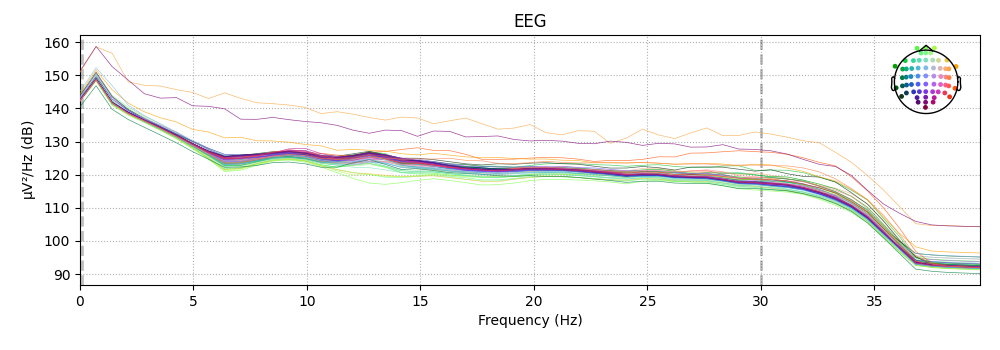

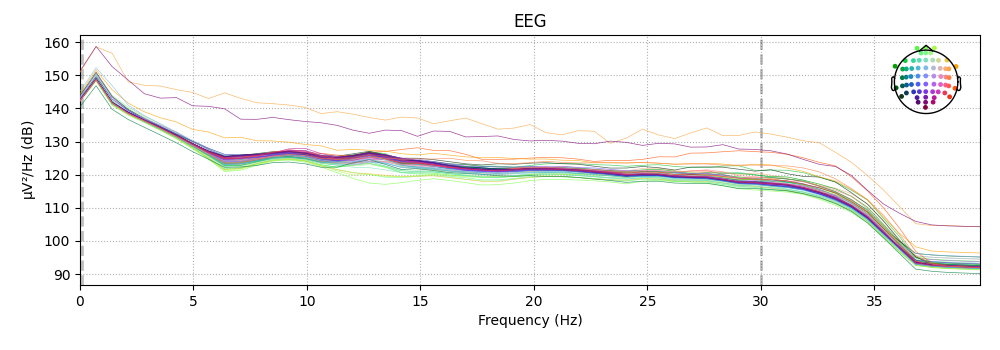

In [5]:
# Filter settings
low_cut = 0.1
hi_cut  = 30

raw.load_data()
raw_filtered = raw.copy().filter(low_cut, hi_cut)
raw_filtered.compute_psd(fmax=40).plot();

In [6]:
raw_filtered.save('data_ukazka/sub-S01/filtered.fif', overwrite=True)

# můj notebook nemá dost paměti
del raw_filtered

Overwriting existing file.
Writing /home/katterrina/fi_muni/0_diplomka/data_ukazka/sub-S01/filtered.fif


/tmp/ipykernel_27502/2385637047.py:1: RuntimeWarning: This filename (/home/katterrina/fi_muni/0_diplomka/data_ukazka/sub-S01/filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filtered.save('data_ukazka/sub-S01/filtered.fif', overwrite=True)


Closing /home/katterrina/fi_muni/0_diplomka/data_ukazka/sub-S01/filtered.fif
[done]


In [7]:
# Filter settings
ica_low_cut = 1.0       # For ICA, we filter out more low-frequency power
hi_cut  = 30

raw_ica = raw.copy().filter(ica_low_cut, hi_cut)

# můj notebook nemá dost paměti
del raw # protože už mám kopii pro ica i filtered

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 4785 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s


In [8]:
# Break raw data into 10 s epochs, because 1 s (used in tutorial) needs too much memory 
tstep = 10.0
events_ica = mne.make_fixed_length_events(raw_ica, duration=tstep)
epochs_ica = mne.Epochs(raw_ica, events_ica,
                        tmin=0.0, tmax=tstep,
                        baseline=None,
                        preload=True)
del events_ica

Not setting metadata
102 matching events found
No baseline correction applied
0 projection items activated


Using data from preloaded Raw for 102 events and 14501 original time points ...
0 bad epochs dropped


In [9]:
reject = get_rejection_threshold(epochs=epochs_ica,decim=2,random_state=42);
reject

Estimating rejection dictionary for eeg
Estimating rejection dictionary for eog


{'eeg': 145.67250998152952, 'eog': 169.7566186007477}

In [10]:
# Fit ICA
ica = mne.preprocessing.ICA(n_components=.99, # Specify n_components as a decimal to set % explained variance
                            random_state=42)

ica.fit(epochs_ica,reject=reject)

Fitting ICA to data using 60 channels (please be patient, this may take a while)


/tmp/ipykernel_27502/1067751212.py:5: RuntimeWarning: The following parameters passed to ICA.fit() will be ignored, as they only affect raw data (and it appears you passed epochs): reject
  ica.fit(epochs_ica,reject=reject)


Selecting by explained variance: 15 components
Fitting ICA took 78.0s.


Method,fastica
Fit,32 iterations on epochs (1479102 samples)
ICA components,15
Available PCA components,60
Channel types,eeg
ICA components marked for exclusion,—


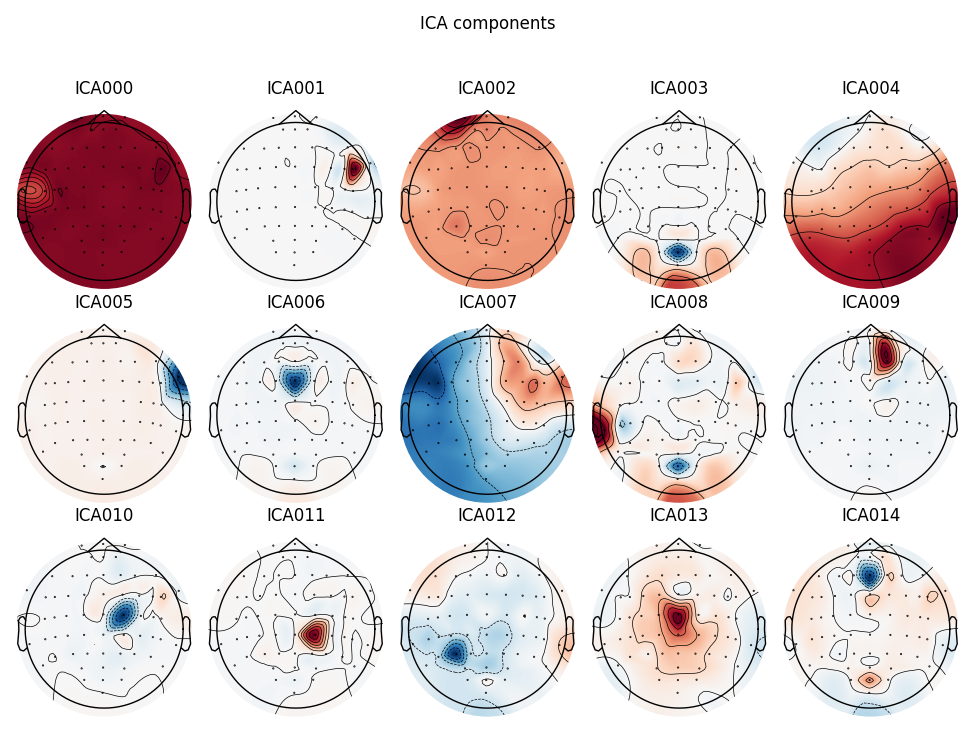

In [11]:
ica.plot_components(); # popisky, co by to mohlo zanmenat: https://neuraldatascience.io/7-eeg/erp_artifacts.html

Using EOG channel: EOG
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 14500 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
-

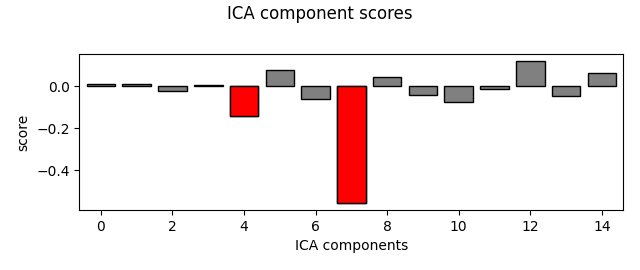

In [12]:
ica_z_thresh = 1.96 
eog_indices, eog_scores = ica.find_bads_eog(raw_ica, threshold=ica_z_thresh)
ica.exclude = eog_indices

ica.plot_scores(eog_scores);
del eog_indices
del eog_scores

In [13]:
ica.save('data_ukazka/sub-S01/ica.fif', overwrite=True);

Overwriting existing file.
Writing ICA solution to /home/katterrina/fi_muni/0_diplomka/data_ukazka/sub-S01/ica.fif...


/tmp/ipykernel_27502/1560287628.py:1: RuntimeWarning: This filename (data_ukazka/sub-S01/ica.fif) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ica.save('data_ukazka/sub-S01/ica.fif', overwrite=True);


Opening raw data file data_ukazka/sub-S01/filtered.fif...


/tmp/ipykernel_27502/3670139774.py:1: RuntimeWarning: This filename (data_ukazka/sub-S01/filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_filtered = mne.io.read_raw_fif('data_ukazka/sub-S01/filtered.fif')


    Range : 0 ... 1482441 =      0.000 ...  1022.373 secs
Ready.
Using matplotlib as 2D backend.


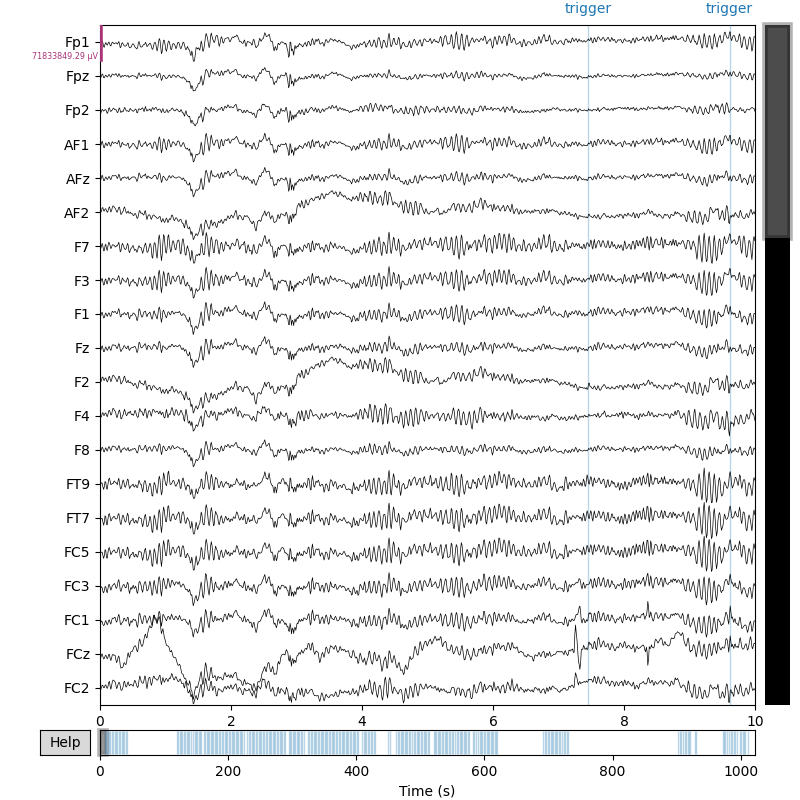

In [14]:
raw_filtered = mne.io.read_raw_fif('data_ukazka/sub-S01/filtered.fif')
raw_filtered.plot(scalings='auto');

In [15]:
events, event_dict = mne.events_from_annotations(raw_filtered)

Used Annotations descriptions: ['trigger']


In [16]:
# Epoching settings
tmin =  -.200  # start of each epoch (in sec)
tmax =  1.000  # end of each epoch (in sec)
baseline = (None, 0)

# Create epochs
epochs = mne.Epochs(raw_filtered,
                    events, event_dict,
                    tmin, tmax,
                    baseline=baseline, 
                    preload=True) 

Not setting metadata
267 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 267 events and 1741 original time points ...
0 bad epochs dropped


In [17]:
epochs

Number of events,267
Events,trigger: 267
Time range,-0.200 – 1.000 s
Baseline,-0.200 – 0.000 s


In [18]:
epochs[0]

Number of events,1
Events,trigger: 1
Time range,-0.200 – 1.000 s
Baseline,-0.200 – 0.000 s


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


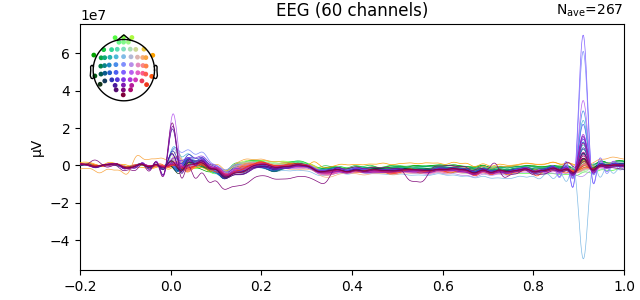

In [19]:
epochs.average().plot(spatial_colors=True); # before removing ICs, so that we can compare with post-ICA below to see the effect of artifact removal

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


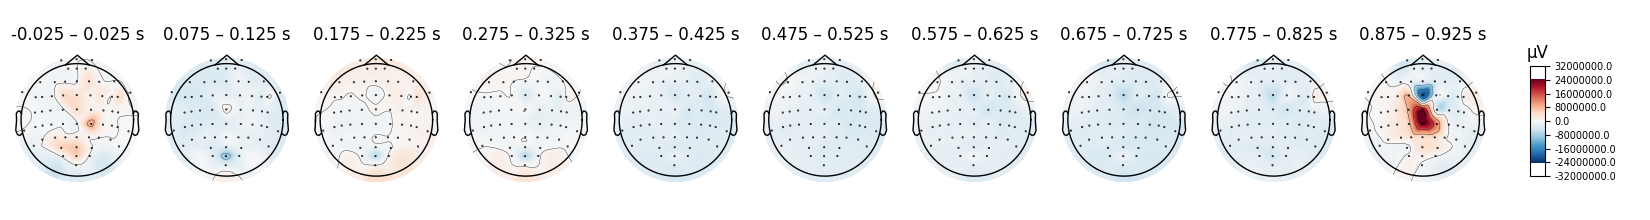

: 

In [27]:
# Specify times to plot at, as [min],[max],[stepsize]
times = np.arange(0, tmax, 0.1)

epochs.average().plot_topomap(times=times, average=0.050);

# v návodu: This will confirm that the artifacts are focused over the electrodes close to the eyes.
# TODO nesedí s návodem, zjistit problém

In [21]:
epochs_postica = ica.apply(epochs.copy())

Applying ICA to Epochs instance


/tmp/ipykernel_27502/610069079.py:1: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  epochs_postica = ica.apply(epochs.copy())


    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 60 PCA components


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


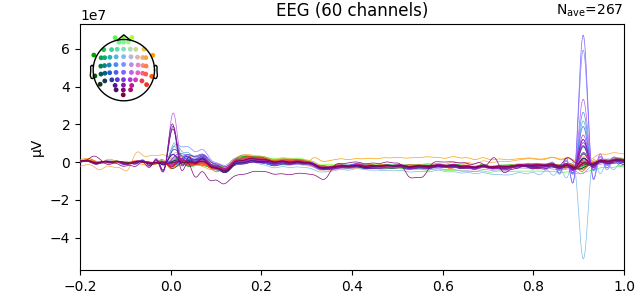

In [22]:
epochs_postica.average().plot(spatial_colors=True);

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


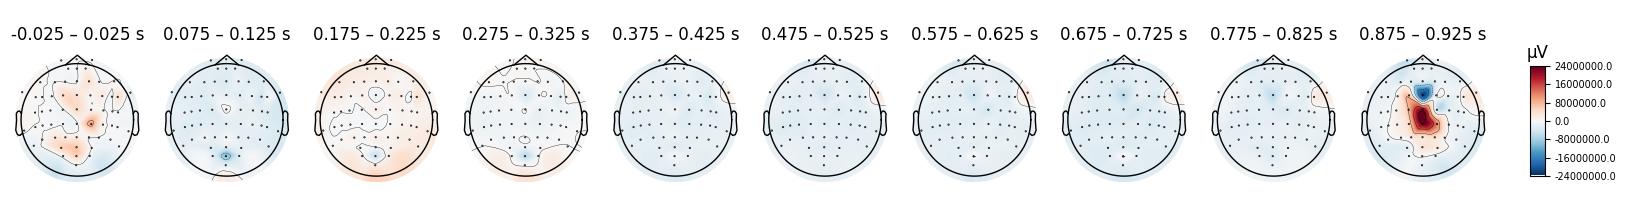

In [23]:
# Specify times to plot at, as [min],[max],[stepsize]
times = np.arange(0, tmax, 0.1)

epochs_postica.average().plot_topomap(times=times, average=0.050);

# TODO tohle je prostě divné

Aktuální závěr

Pokračovala jsem v návodu do kapitoly https://neuraldatascience.io/7-eeg/erp_rereferencing.html, u které nevím, jestli je užitečná, tak končím. Možná se ještě bude hodit https://neuraldatascience.io/7-eeg/erp_averaging.html. Odstraňování artefaktů se evidentně moc nepovedlo, nevím, proč. Na stránkách MNE je ještě jeden návod, potenciálně projít ten https://mne.tools/stable/auto_tutorials/preprocessing/10_preprocessing_overview.html#sphx-glr-auto-tutorials-preprocessing-10-preprocessing-overview-py.